In [ ]:
# Copyright (c) 2025 Intel Corporation
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#      http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
from functools import partial

import numpy as np
from datasets import load_dataset
from optimum.intel.openvino import OVModelForCausalLM
from transformers import AutoTokenizer

import nncf

In [ ]:
MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = OVModelForCausalLM.from_pretrained(MODEL_ID, export=True, load_in_8bit=False, compile=False)

In [4]:
ov_model_fp = model.model

In [4]:
def transform_fn(data, tokenizer):
    tokenized_text = tokenizer(data["text"], return_tensors="np")
    input_ids = tokenized_text["input_ids"]
    attention_mask = tokenized_text["attention_mask"]

    inputs = {}
    inputs["input_ids"] = input_ids
    inputs["attention_mask"] = tokenized_text["attention_mask"]
    position_ids = np.cumsum(attention_mask, axis=1) - 1
    position_ids[attention_mask == 0] = 1
    inputs["position_ids"] = position_ids

    batch_size = input_ids.shape[0]
    inputs["beam_idx"] = np.arange(batch_size, dtype=int)

    return inputs


quantization_dataset = nncf.Dataset(dataset, partial(transform_fn, tokenizer=tokenizer))

In [ ]:
from profiler import NNCFProfiler

profiler = NNCFProfiler(pattern = r'.*\.self_attn\.k_proj/ov_ext::linear/MatMul', 
                        dataset=quantization_dataset, 
                        num_samples=2)

In [ ]:
data_fp = profiler.collect_activations(ov_model_fp)

In [9]:
data_fp.keys()

dict_keys(['__module.model.layers.0.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.1.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.2.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.3.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.4.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.5.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.6.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.7.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.8.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.9.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.10.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.11.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.12.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.13.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.14.self_attn.k_proj/ov_ext::linear/Mat

In [11]:
stats_fp = profiler.calculate_stats(data_fp, statistics=["min", "max", "mean"])
stats_fp.head()

,name,type,min,max,mean
0,__module.model.layers.0.self_attn.k_proj/ov_ex...,in,-3.702809,4.830170,0.000816
1,__module.model.layers.0.self_attn.k_proj/ov_ex...,out,-13.699491,5.540934,-0.086840
2,__module.model.layers.1.self_attn.k_proj/ov_ex...,in,-8.973475,2.948636,-0.004756
3,__module.model.layers.1.self_attn.k_proj/ov_ex...,out,-6.133480,8.753073,0.074276
4,__module.model.layers.2.self_attn.k_proj/ov_ex...,in,-7.766637,3.266993,-0.004558


In [ ]:
# It's possible to register your own statistics

@NNCFProfiler.statistic("percentile_95")
def _stat_percentile_95(vals: np.ndarray) -> float:
    """Calculate the 95th percentile of activations."""
    return float(np.percentile(vals, 95))


stats_fp = profiler.calculate_stats(data_fp, statistics=["min", "max", "mean", "percentile_95"])
stats_fp.head()

,name,type,min,max,mean,percentile_95
0,__module.model.layers.0.self_attn.k_proj/ov_ex...,in,-3.702809,4.830170,0.000816,0.011473
1,__module.model.layers.0.self_attn.k_proj/ov_ex...,out,-13.699491,5.540934,-0.086840,1.881651
2,__module.model.layers.1.self_attn.k_proj/ov_ex...,in,-8.973475,2.948636,-0.004756,0.050166
3,__module.model.layers.1.self_attn.k_proj/ov_ex...,out,-6.133480,8.753073,0.074276,3.285733
4,__module.model.layers.2.self_attn.k_proj/ov_ex...,in,-7.766637,3.266993,-0.004558,0.101055


In [ ]:
from nncf import CompressWeightsMode
from nncf import compress_weights

ov_model_int8 = compress_weights(ov_model_fp, mode=CompressWeightsMode.INT8_SYM, ratio=1.0)

In [9]:
data_int8 = profiler.collect_activations(ov_model_int8)

In [ ]:
comp_res = profiler.compare_activations(data_fp, 
                                        data_int8, 
                                        metrics=["mean_diff", "std_diff"], 
                                        statistics = ["min", "max", "mean"])
comp_res.head()

,name,type,min_data1,max_data1,mean_data1,min_data2,max_data2,mean_data2,mean_diff,std_diff
0,__module.model.layers.0.self_attn.k_proj/ov_ex...,in,-3.702809,4.830170,0.000816,-3.701592,4.813562,0.000813,0.000003,0.000686
1,__module.model.layers.0.self_attn.k_proj/ov_ex...,out,-13.699491,5.540934,-0.086840,-13.664916,5.459719,-0.086497,-0.000343,0.007337
2,__module.model.layers.1.self_attn.k_proj/ov_ex...,in,-8.973475,2.948636,-0.004756,-8.986747,2.947640,-0.004748,-0.000008,0.001551
3,__module.model.layers.1.self_attn.k_proj/ov_ex...,out,-6.133480,8.753073,0.074276,-6.118840,8.763062,0.074142,0.000134,0.011611
4,__module.model.layers.2.self_attn.k_proj/ov_ex...,in,-7.766637,3.266993,-0.004558,-7.765649,3.290504,-0.004616,0.000058,0.003471


In [ ]:
# You can register your own function for comparing statistics

@NNCFProfiler.comparator("relative_diff")
def _relative_diff(a: np.ndarray, b: np.ndarray) -> float:
    """Calculate the mean relative difference between two activation arrays."""
    epsilon = 1e-8
    return float((np.abs(a - b) / (np.abs(a) + epsilon)).mean())

In [ ]:
comp_res = profiler.compare_activations(data_fp, 
                                        data_int8, 
                                        metrics=["mean_diff", "std_diff", "relative_diff"], 
                                        statistics = ["min", "max", "mean"])
comp_res.head()

,name,type,min_data1,max_data1,mean_data1,min_data2,max_data2,mean_data2,mean_diff,std_diff,relative_diff
0,__module.model.layers.0.self_attn.k_proj/ov_ex...,in,-3.702809,4.830170,0.000816,-3.701592,4.813562,0.000813,0.000003,0.000686,0.083059
1,__module.model.layers.0.self_attn.k_proj/ov_ex...,out,-13.699491,5.540934,-0.086840,-13.664916,5.459719,-0.086497,-0.000343,0.007337,0.038519
2,__module.model.layers.1.self_attn.k_proj/ov_ex...,in,-8.973475,2.948636,-0.004756,-8.986747,2.947640,-0.004748,-0.000008,0.001551,0.16398
3,__module.model.layers.1.self_attn.k_proj/ov_ex...,out,-6.133480,8.753073,0.074276,-6.118840,8.763062,0.074142,0.000134,0.011611,0.026449
4,__module.model.layers.2.self_attn.k_proj/ov_ex...,in,-7.766637,3.266993,-0.004558,-7.765649,3.290504,-0.004616,0.000058,0.003471,0.220715


In [ ]:
# It's also possible to register your own visualizer (see the implemenation in nncf/tools/profiler.py)

# @NNCFProfiler.visualizer("compare_detailed")
# def _compare_detailed_plot(
#     data1: ActivationData,
#     data2: ActivationData,
#     activation_type: Optional[str] = None,
#     bins: int = 100,
#     show_histograms: bool = True,
#     show_summary: bool = True,
#     display_figures: bool = False,
#     data1_label: str = 'data1',
#     data2_label: str = 'data2',
#     **kwargs
# ): 

In [ ]:
all_figs, summary_figs = profiler.plot("compare_detailed", 
                                       data_fp, 
                                       data_int8, 
                                       data1_label='data_fp', 
                                       data2_label = 'data_int8', 
                                       display_figures=False)

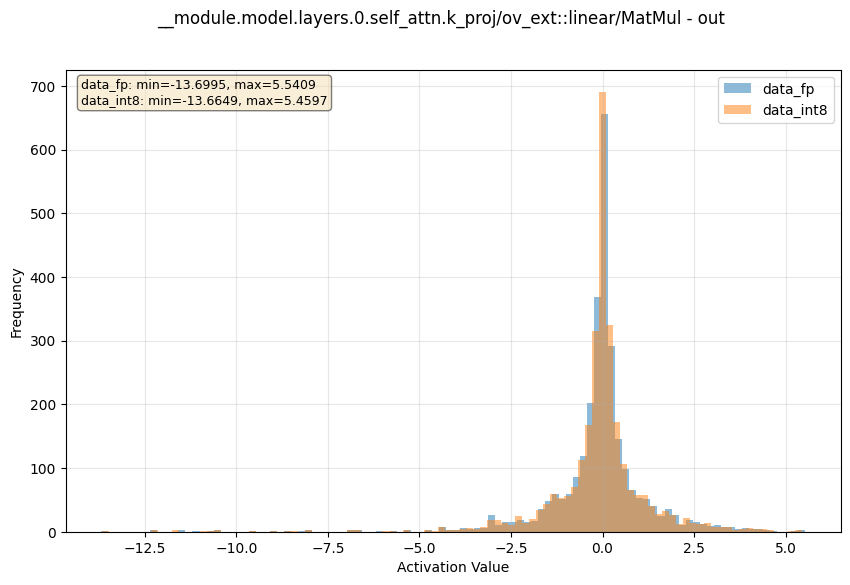

In [21]:
from IPython.display import display

display(all_figs['__module.model.layers.0.self_attn.k_proj/ov_ext::linear/MatMul']['out'])

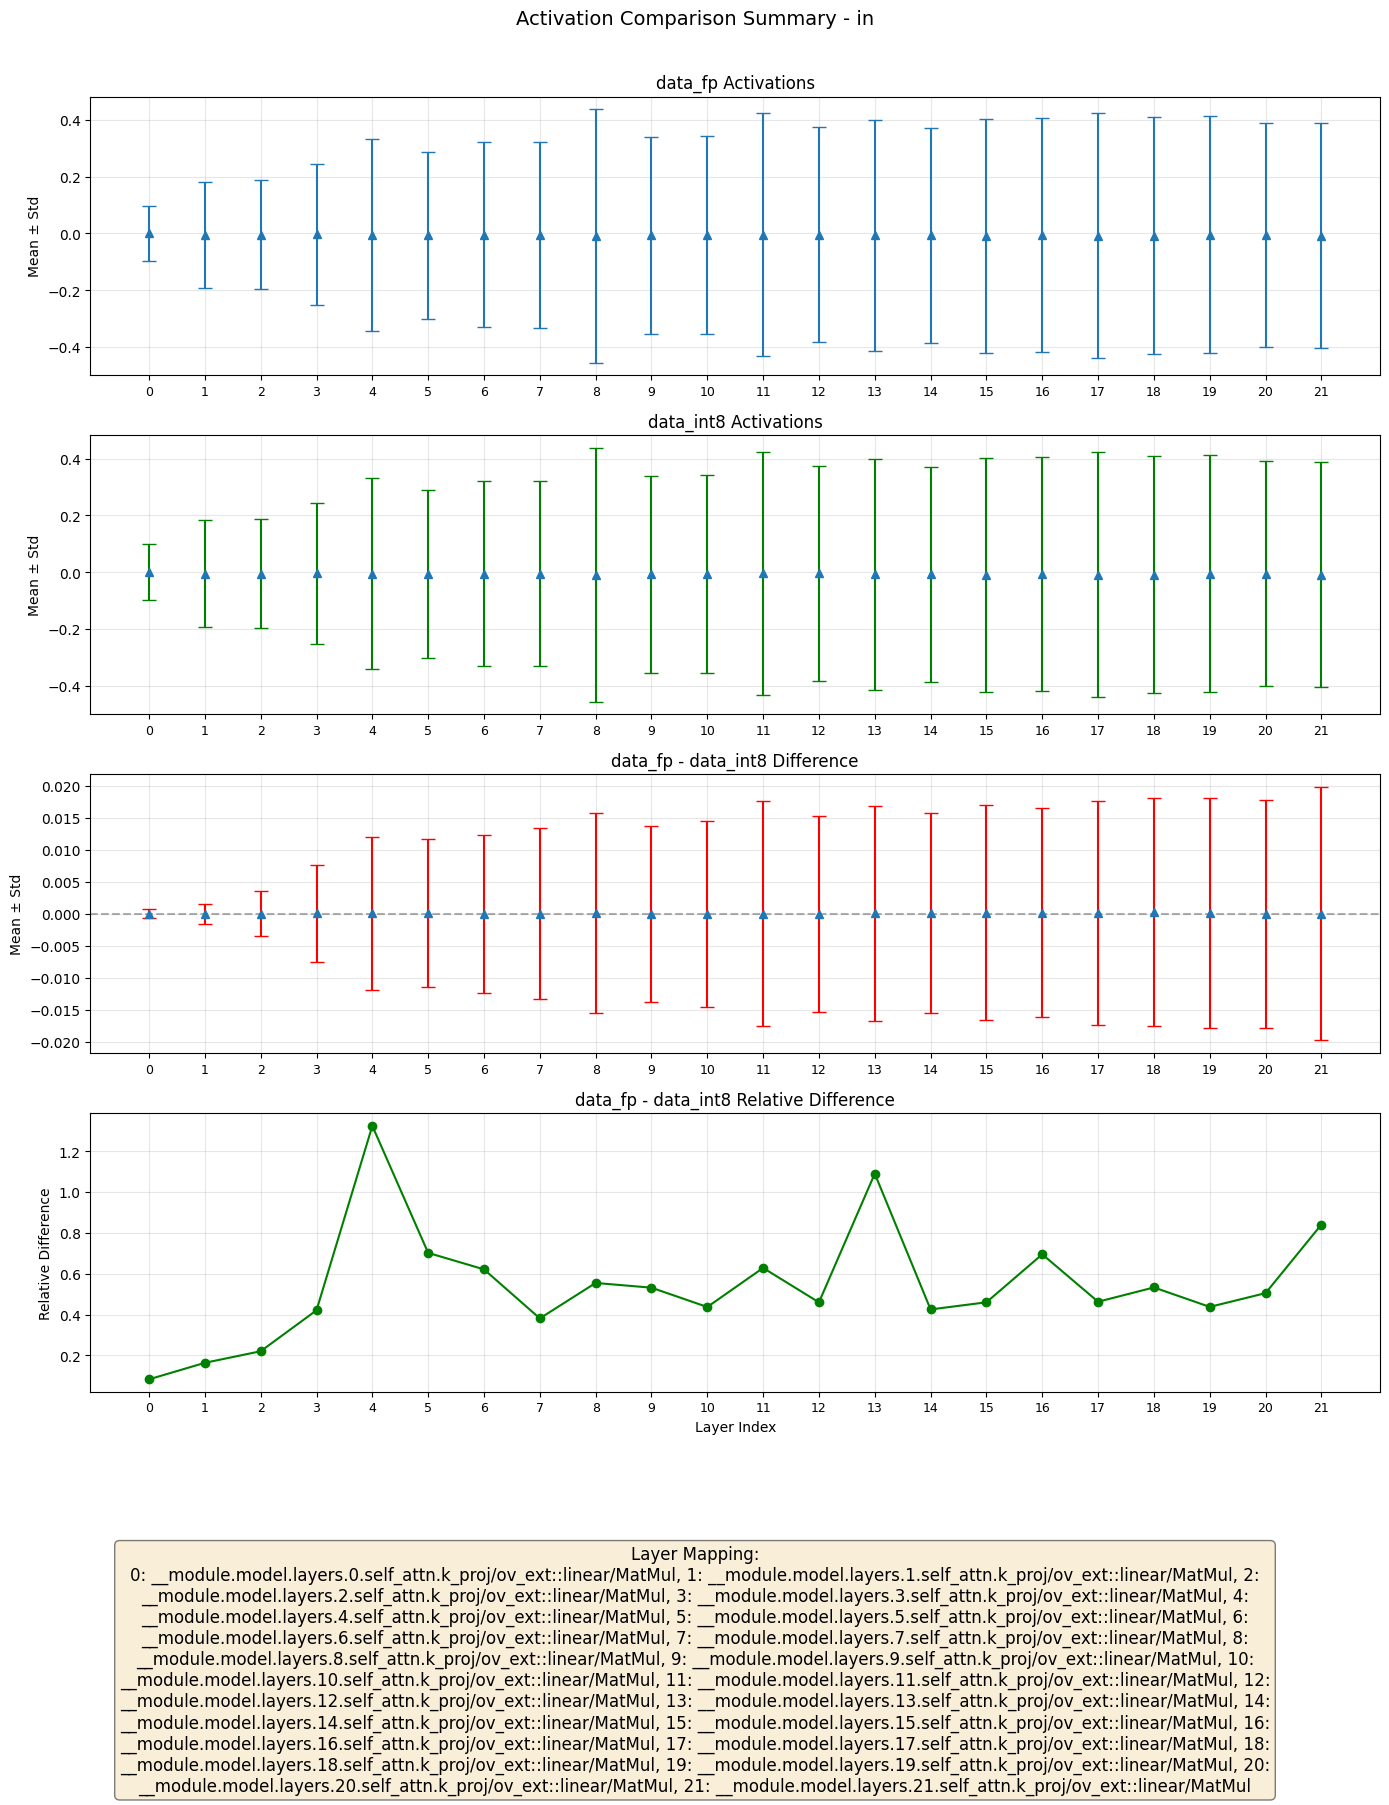

In [13]:
display(summary_figs['in'])